[![Troy Tompkins](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/als) ![Troy](https://github.com/ttompk/musings/blob/master/images/name.png?raw=true)

# Fastai Template for Image Segmentation
---

[Today's Date]  
Written in python: 3.6.8

In [1]:
from platform import python_version
print('Your python version: {}'.format(python_version()))

Your python version: 3.6.8


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image sementation using the Fastai library. Segmentation is predicting the class of each pixel in an image.

### Directive/Objective
Identify NeuN stained neurons in microscopy slides and measure amount of co-localization with other staining markers (different channels than NeuN). 

**Part 1**  
Identify the NeuN-stained neurons using the fastai library.

**Part 2**  
Perform co-localization of the neurons with other channels.

**Part 3**  
Package the tool for use in ImageJ - either as a plug-in or other method (see ImageJ developer tools).


### Data Source
Each image in the 'images' subfolder has an equivalent in 'labels'. The 'labels' are the segmentation masks. 



## 2. Libraries
---

In [1]:
# basic kit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pandas_profiling
import re
import collections

In [2]:
from fastai.vision import *


In [3]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

In [4]:
# Display images
from IPython.display import Image, display
import PIL.Image

def display_img(folder_path, file_names, width=100, height=100):
    '''
    displays images in line
    ---
    folder_path:   str. folder that contains the images. ex: /Users/shared/.fastai/data/camvid_tiny/labels
    file_names:    list. filenames as strings.
    '''
    for imageName in file_names:
        imageName = folder_path+'/'+imageName
        display(Image(filename=imageName, width=width, height=height))

## 4. Data
---

#### 4.1. Downaloading Data and ETL

How to download datasets. 2 sources:

1. Fastai:  Fastai has it's own datasets which can be downloaded using the 'untar_data' function. These data are provided as tgz files.  
2. Non-fastai:  The 'download_data' function downloads data fom the internet and places it into a 'data' folder.

The default folder for downloading data is: `~/.fastai`

**Fastai data:**  
`untar_data(url:str, fname:PathOrStr=None, dest:PathOrStr=None, data=True, force_download=False)`

Note: `untar_data` only works for fastai datasets. In general, `untar_data` uses a `url` to download a tgz file under `fname`, and then un-tgz fname into a folder under `dest`.

**Non-fastai data:**  
`download_data(url:str, fname:PathOrStr=None, data:bool=True, ext:str='.tgz')`

Download `url` to destination `fname`. Note: If the data file already exists in a `data` directory inside the notebook, that data file will be used instead of the one present in the default folder (`~/.fastai`). 

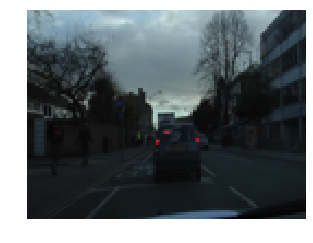

In [9]:
# this downloads the 'street' images dataset from fastai website
camvid = untar_data(URLs.CAMVID_TINY)   # untar's the data downloaded from fastai
path_lbl = camvid/'labels'   # labels go here
path_img = camvid/'images'   # images go here

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

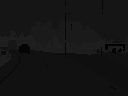

In [5]:
folder_path = '/Users/shared/.fastai/data/camvid_tiny/labels'
file_names = ['0006R0_f00960_P.png']
display_img(folder_path, file_names, 400, 400)
# all the images are very faint

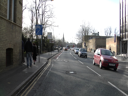

In [7]:
# display image inline using PIL library
PIL.Image.open('/Users/shared/.fastai/data/camvid_tiny/images/0016E5_02250.png')

In [8]:
# display image in a separate window using PIL library
im = PIL.Image.open('/Users/shared/.fastai/data/camvid_tiny/images/0016E5_02250.png')
im.show()

In [10]:
# load the class definitions
codes = np.loadtxt(camvid/'codes.txt', dtype=str)    # these are the classes

# maps each image filename with corresponding mask filename
# this function gets called when we define a 'data' object for training/validation
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'   

In [1]:
# what are the classes?
codes

NameError: name 'codes' is not defined

In [12]:
# what's the path for the images used for training?
path_img.ls()[0]

PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_006750.png')

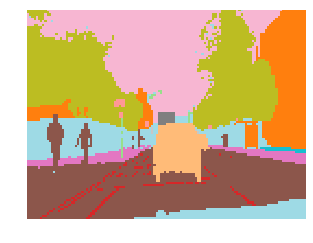

In [13]:
# Display the masks
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

#### 4.2 Define data object

In [14]:
# load image data from folder
data = (SegmentationItemList.from_folder(path_img)   # load the data from a folder
        .split_by_rand_pct()   # split data into training and validaiton sets by random percent
        #.split_by_fname_file('../valid.txt')   # split data by folder
        .label_from_func(get_y_fn, classes=codes)  # label data using 'get_y_fn' function
        .transform(get_transforms(), tfm_y=True, size=128)  # flip image horizontally
        .databunch(bs=16, path=camvid)  # create a databunch
        .normalize(imagenet_stats))  # normalize for resnet

overlay of masks on images


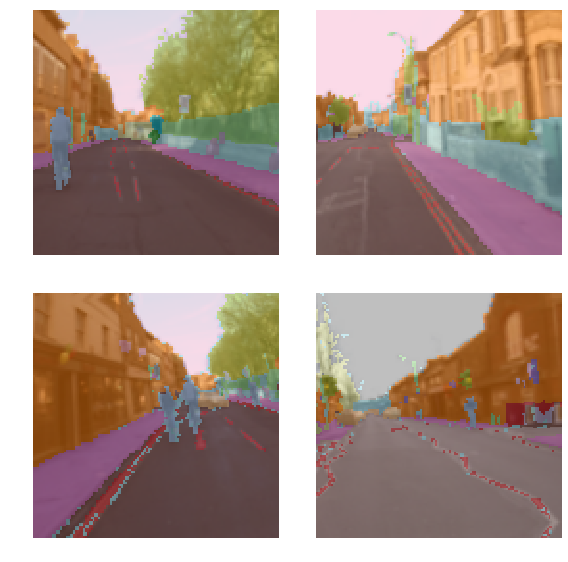

In [15]:
print("overlay of masks on images")
data.show_batch(rows=2, figsize=(8,8))

## 5. Training
---

#### **5.1. Model**

Choosing the model architecture.  

The model architecture can be provided using fastai syntax. Example:
- `model = simple_cnn((3,16,16,2))`  builds a cnn model with a binary output

The fastai library includes several pretrained models from torchvision, namely:
- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet  

On top of the models offered by torchvision, fastai has implementations for the following models:

- Darknet architecture, which is the base of [Yolo v3](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
- Unet architecture based on a pretrained model. The original unet is described [here](https://arxiv.org/abs/1505.04597), the model implementation is detailed in [models.unet](https://docs.fast.ai/vision.models.unet.html#vision.models.unet)
- Wide resnets architectures, as introduced in [this article](https://arxiv.org/abs/1605.07146)

In [8]:
# simple CNN
#model = simple_cnn((3,16,16,2))    # syn
model = models.resnet18

#### **5.2. Optimization Function**

Choose the optimization function. Options include:
- 'Adam'

Really Adam is the only one to use (for now). Uses decoupled weight regularization. [ref](https://arxiv.org/abs/1711.05101)

In [ ]:
opt_func = 'Adam'

#### **5.2. Learner**

Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.

`Learner (data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)`

In [9]:
#learn = Learner(data, model)
#learn = cnn_learner(data, model)
learn = unet_learner(data=data, model=model, opt_func=opt_func)

#### 5.2.1. Learning Rate Finder

The learning rate finder funciton is performed each time the model architecture is changed. Will perform a learning rate search step-wise through a range. 

Other strategies for hyperparameter optimization include:   
Uninformed
- grid search (worst, uninformed)
- random search  (better, uninformed)  

Bayesian optimization (sequential model-based optimization)
- gaussian processes
- random forest regression
- Tree of Parzen Estimators (TPE) (hyperopt) [ref](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)


Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.


`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

In [ ]:
# run learning rate finder
learn.lr_find()

In [ ]:
# plot the finder results
learn.recorder.plot()

#### **5.3. Metrics**

In [16]:
# Metrics
# metrics always calculated on the validation set
#learn.metrics=[accuracy]    # accuracy does not work on multilabel classification

#### **5.4. Callbacks**

In [17]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this funciton not working


#### **5.5. Fit**

fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)

In [10]:
#n_epochs = 3
#learn.fit(epochs=n_epochs, callbacks=cb)
learn.fit_one_cycle(cyc_len=3, 1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,10.080372,2.741252,08:52
1,6.027252,2.071771,07:50
2,4.502634,2.038171,07:48


#### 6. Show Results
---

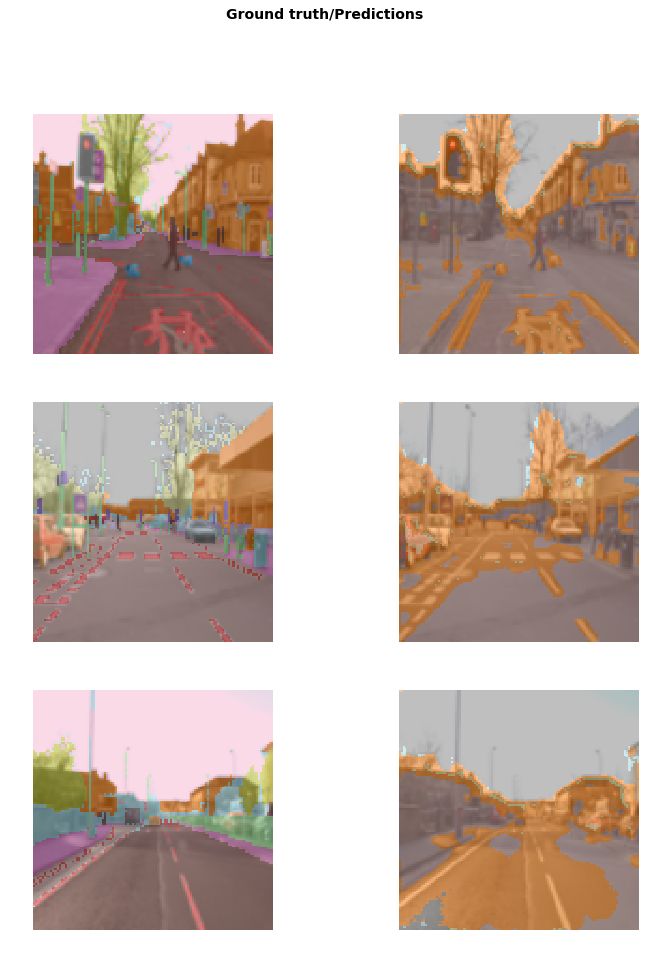

In [11]:
#learn.show_results()
learn.show_results(rows=3, figsize=(12,15))

## 7. Next Steps
---